In [1]:
%load_ext autoreload
%autoreload 2
%load_ext yamlmagic

# Setup

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import scribbleprompt

import numpy as np
import torch

# https://github.com/JJGO/pylot
from pylot.experiment.util import eval_config

# for helpful plotting functions
os.environ['NEURITE_BACKEND'] = 'pytorch'
import neurite as ne

device = 'cuda' if torch.cuda.is_available() else 'cpu'
os.environ['CUDA_VISIBLE_DEVICES'] = str(1)

# Load Example

img: torch.Size([1, 1, 128, 128]) 0.0 1.0


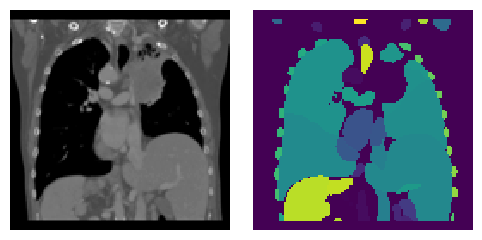

(<Figure size 500x250 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

In [3]:
from PIL import Image

examples_dir = '../demos/examples'
img_orig = Image.open(examples_dir + "/" + 'TotalSegmentator_midslice_res256_s0716.png')
seg_orig = np.load(examples_dir + "/" + 'TotalSegmentator_midslice_res256_s0716_seg.npy')

# Preprocessed Image
img = torch.tensor(np.asarray(img_orig.resize((128,128)).convert('L')))/255
img = img[None,None,...].float().to(device)/img.max()
print("img:", img.shape, img.min().item(), img.max().item())

seg = torch.tensor(seg_orig, device=device)
seg_onehot = torch.stack([(seg == i).float() for i in range(seg.max())])
seg_onehot = torch.nn.functional.interpolate(seg_onehot[None,...], (128,128))

ne.plot.slices([img.cpu(), (seg_onehot > 0.5).int().argmax(1).cpu()], width=5, cmaps=['gray', 'viridis'])

Let's combine a few of the labels so it's easier to see the interactions.

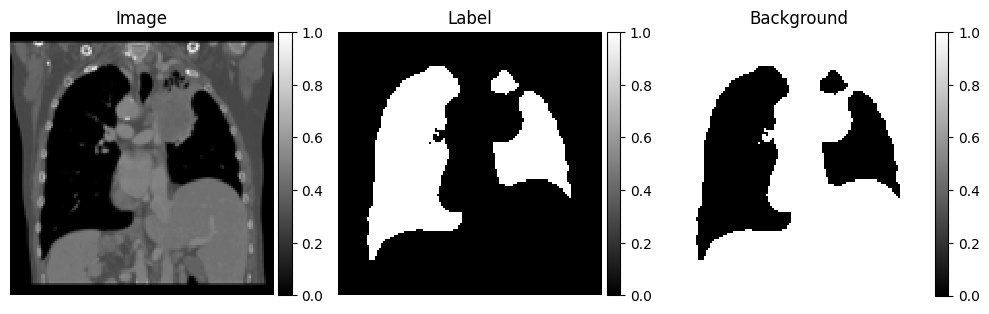

In [4]:
seg = torch.cat([seg_onehot[:,i] for i in [41,42,43,44,45]], dim=0).any(0).float().cpu()
ne.plot.slices([img.cpu(), seg, 1-seg], titles=['Image', 'Label', 'Background'], do_colorbars=True, width=10)

seg = seg[None,None,...].float().to(device)

# Training Prompt Generator

In [ ]:
%%yaml train_config
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
bbox_embed:
  _fn: scribbleprompt.interactions.embed.bbox_shaded
box_generators:
- _class: scribbleprompt.interactions.boxes.UniformBBox 
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_neg_click_generators:
- _class: scribbleprompt.interactions.clicks.RandomClick
- _class: scribbleprompt.interactions.clicks.RandBorderClick
init_pos_click_generators:
- _class: scribbleprompt.interactions.clicks.RandomClick
- _class: scribbleprompt.interactions.clicks.ComponentCenterClick
- _class: scribbleprompt.interactions.clicks.RandBorderClick
scribble_generators:
- _class: scribbleprompt.interactions.scribbles.LineScribble
- _class: scribbleprompt.interactions.scribbles.CenterlineScribble
- _class: scribbleprompt.interactions.scribbles.ContourScribble
correction_click_generators:
- _class: scribbleprompt.interactions.clicks.RandomClick
- _class: scribbleprompt.interactions.clicks.ComponentCenterClick
- _class: scribbleprompt.interactions.clicks.RandBorderClick
correction_clicks: [1,3]
correction_scribbles: [1,3]
init_pos_click: [1,3]
init_neg_click: [0,3]
init_neg_scribble: [0,3]
init_pos_scribble: [1,3]
prob_bbox: 0.5
prob_click: 0.5
prob_scribble: 0.5
from_logits: true

<IPython.core.display.Javascript object>

In [6]:
# build prompt generator object
prompt_generator = eval_config(train_config)

dict_keys(['img', 'seg', 'box', 'scribble', 'point_coords', 'point_labels', 'x', 'y'])


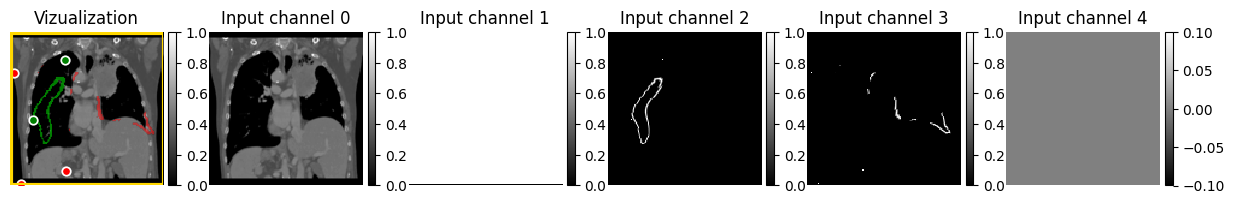

In [7]:
# generate prompts for a given image and segmentation
prompts = prompt_generator(img, seg)
print(prompts.keys())

import matplotlib.pyplot as plt
from scribbleprompt.plot import show_mask,show_points,show_boxes,show_scribbles

# the output is a dictionary with keys 'x' for scribblepprompt-unet input
fig,axes = ne.plot.slices(
    [img.cpu()]+[prompts['x'][0,i,...].cpu() for i in range(5)], 
    titles=["Vizualization"] + [f'Input channel {i}' for i in range(5)], 
    width=15, do_colorbars=True, show=False
)
if 'point_coords' in prompts:
    show_points(prompts['point_coords'].cpu(), prompts['point_labels'].cpu(), ax=axes[0])
if 'scribble' in prompts:
    # thresholding scribbles for visualization
    show_scribbles((prompts['scribble'].cpu() > 0), ax=axes[0])
if 'box' in prompts:
    show_boxes(prompts['box'].cpu(), ax=axes[0])
plt.show()

In [8]:
from scribbleprompt import ScribblePromptUNet
sp_unet = ScribblePromptUNet(version="v1")

def show_step(prompts, yhat, i):
    img = prompts['img'].cpu()
    seg = prompts['seg'].cpu()
    pred = (yhat > 0).cpu() 
    fig,axes = ne.plot.slices(
        [img, img, seg, pred], 
        titles=[f'Input {i}', 'GT Overlayed', 'GT', f'Prediction {i}'], 
        do_colorbars=True, 
        width=10, 
        show=False
    )
    show_mask(seg, ax=axes[1])
    if 'point_coords' in prompts:
        show_points(prompts['point_coords'].cpu(), prompts['point_labels'].cpu(), ax=axes[0])
    if 'scribble' in prompts:
        # thresholding scribbles for visualization
        show_scribbles((prompts['scribble'].cpu() > 0), ax=axes[0])
    if 'box' in prompts:
        show_boxes(prompts['box'].cpu(), ax=axes[0])
    plt.show()

@torch.no_grad()
def run_inference(prompt_generator, steps=5):
    for i in range(steps):
        if i == 0:
            prompts = prompt_generator(img, seg)
        else:
            prompts = prompt_generator.subsequent_prompt(
                # to use as an input to the model in the next iteration
                mask_pred = yhat,
                # to use for calculating error region & sampling interactions
                binary_mask_pred = (yhat>0).int(),
                prev_input = prompts
            )
        x = prompts['x']
        yhat = sp_unet.model(x)
        show_step(prompts, yhat, i)

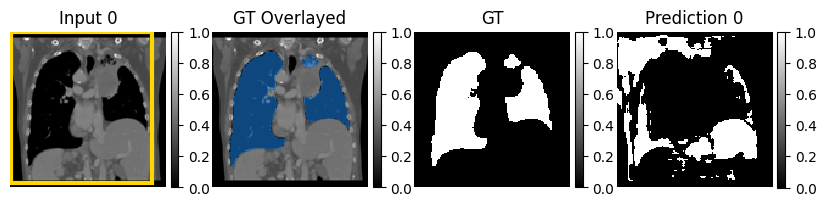

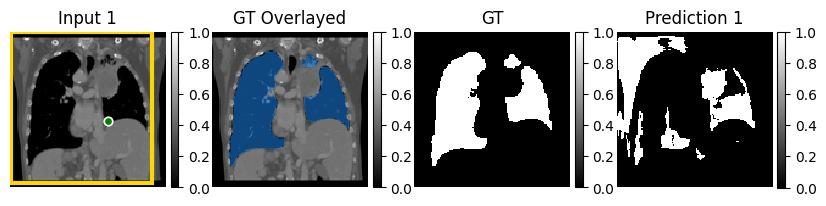

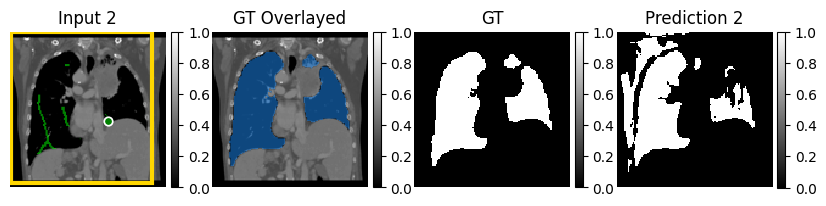

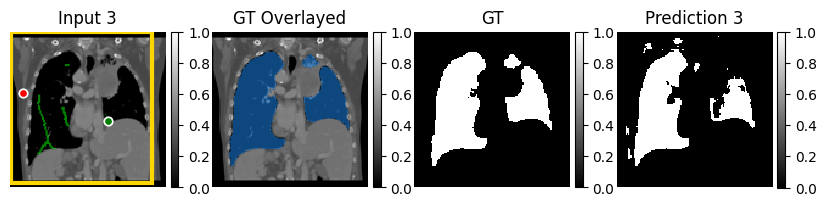

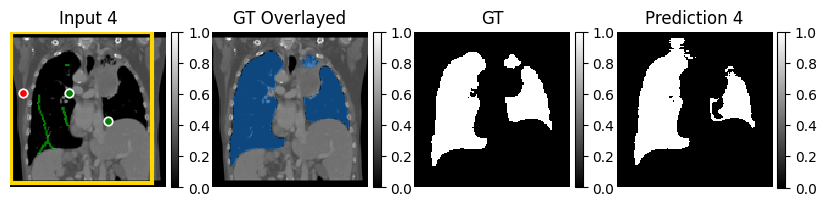

In [9]:
run_inference(prompt_generator, steps=5)

# Evaluation Prompt Generators

## Scribbles

### Centerline Scribbles

1 positive centerline scribble and 1 negative centerline scribble to start, followed by 1 (positive or negative) correction centerline scribble on the error region per step. The correction scribble will be positive or negative depensent on whether the false positive or false negative error region is larger.

In [10]:
%%yaml centerline_scribble
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
train: False
scribble_generators:
  - _class: scribbleprompt.interactions.scribbles.CenterlineScribble
    max_pixels: 128
init_pos_scribble: 1
init_neg_scribble: 1
correction_scribbles: 1
prob_bbox: 0.0
prob_click: 0.0
prob_scribble: 1.0
from_logits: True

<IPython.core.display.Javascript object>

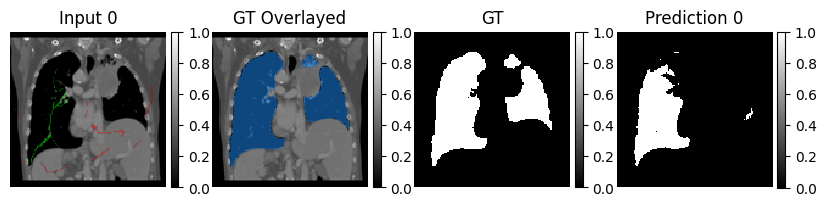

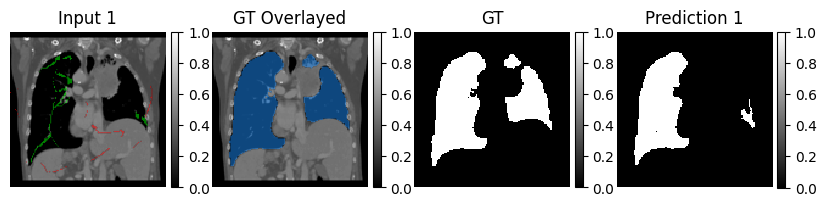

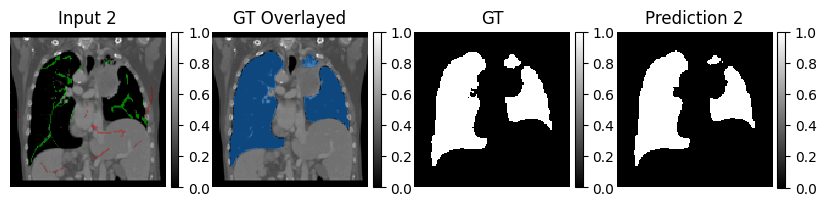

In [11]:
prompt_generator = eval_config(centerline_scribble)
run_inference(prompt_generator, steps=3)

### Line Scribbles

3 positive line scribbles and 3 negative line scribbles to start, followed by 1 (positive or negative) correction line scribble on the error region

In [12]:
%%yaml line_scribble
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
scribble_generators:
  - _class: scribbleprompt.interactions.scribbles.LineScribble
    max_pixels: 128
init_pos_scribble: 3
init_neg_scribble: 3
correction_scribbles: 1
prob_bbox: 0.0
prob_click: 0.0
prob_scribble: 1.0
from_logits: True

<IPython.core.display.Javascript object>

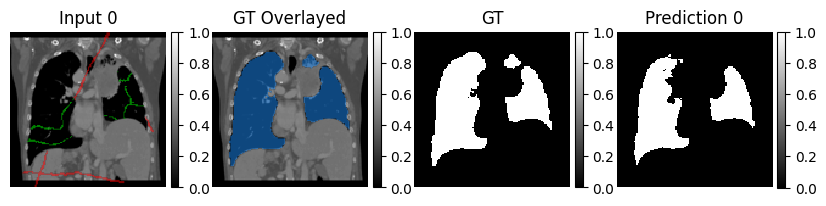

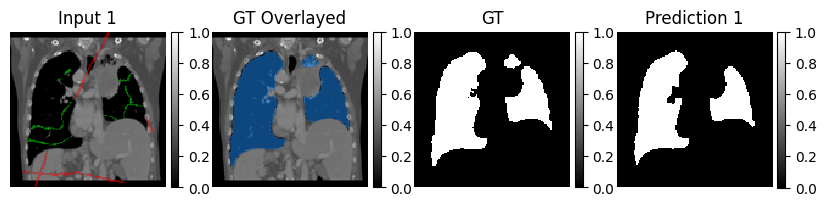

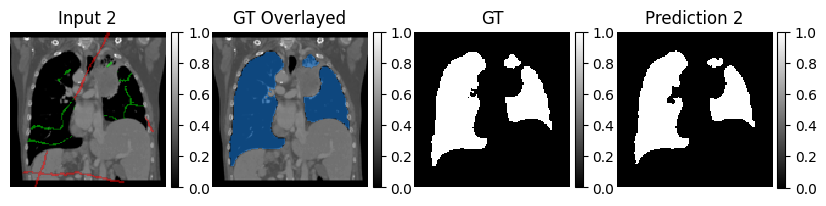

In [13]:
prompt_generator = eval_config(line_scribble)
run_inference(prompt_generator, steps=3)

### Contour Scribbles

1 positive contour scribble and 1 negative contour scribble to start, followed by 1 (positive or negative) correction contour scribble per step on the error region

In [14]:
%%yaml contour_scribble
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
scribble_generators:
  - _class: scribbleprompt.interactions.scribbles.ContourScribble
    max_pixels: 128
init_pos_scribble: 1
init_neg_scribble: 1
correction_scribbles: 1
prob_bbox: 0.0
prob_click: 0.0
prob_scribble: 1.0
from_logits: True

<IPython.core.display.Javascript object>

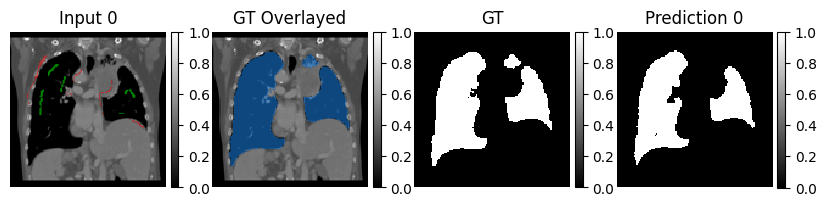

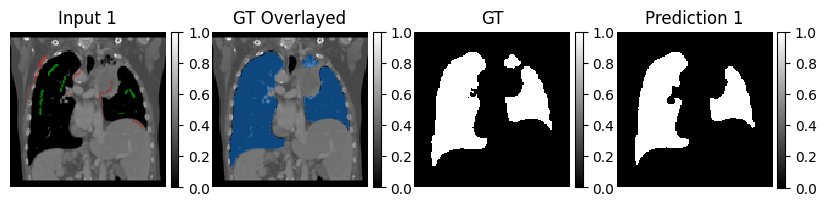

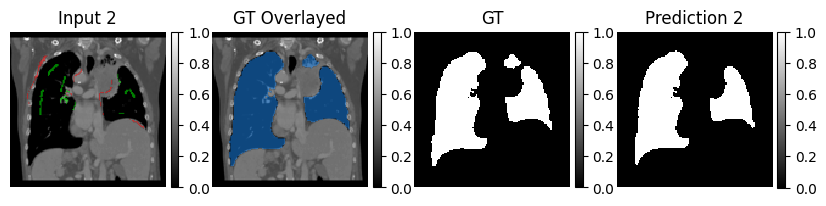

In [15]:
prompt_generator = eval_config(contour_scribble)
run_inference(prompt_generator, steps=3)

## Clicks

### Center Clicks

1 positive center click to start followed by one (positive or negative) correction click in the center of the error region per step

In [16]:
%%yaml clicks_center
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_pos_click_generators:
    - _class: scribbleprompt.interactions.clicks.ComponentCenterClick
      train: False
correction_click_generators:
    - _class: scribbleprompt.interactions.clicks.ComponentCenterClick
      train: False
init_pos_click: 1
init_neg_click: 0
correction_clicks: 1
prob_bbox: 0.0
prob_click: 1.0
prob_scribble: 0.0
from_logits: True

<IPython.core.display.Javascript object>

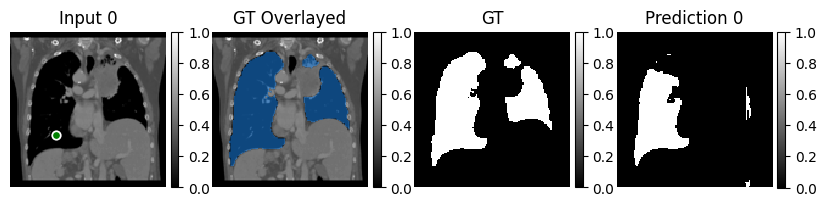

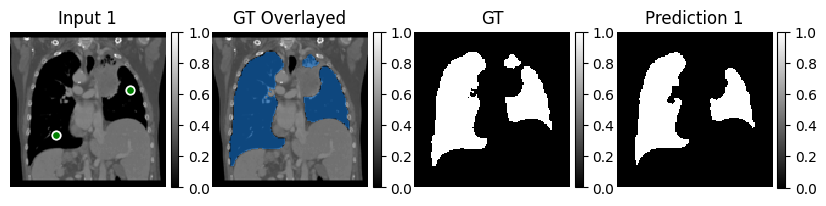

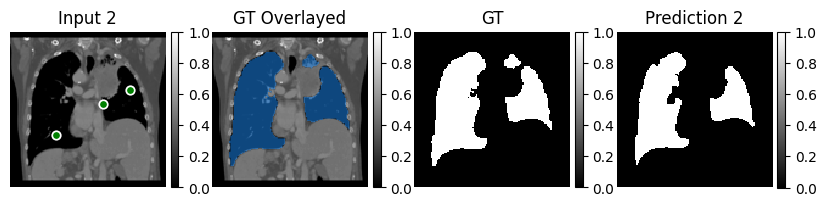

In [17]:
prompt_generator = eval_config(clicks_center)
run_inference(prompt_generator, steps=3)

### Random Clicks

1 random positive click followed by 1 (positive or negative) correction click randomly sampled from the error region per step

In [18]:
%%yaml random_clicks
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_pos_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
correction_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
init_pos_click: 1
init_neg_click: 0
correction_clicks: 1
prob_bbox: 0.0
prob_click: 1.0
prob_scribble: 0.0
from_logits: True

<IPython.core.display.Javascript object>

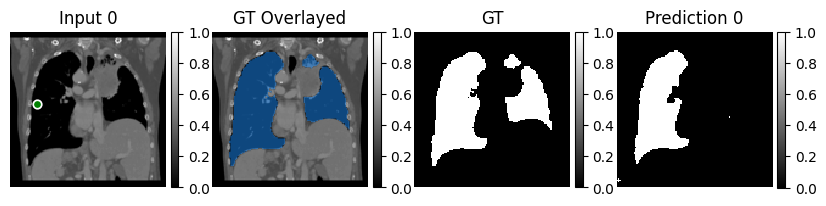

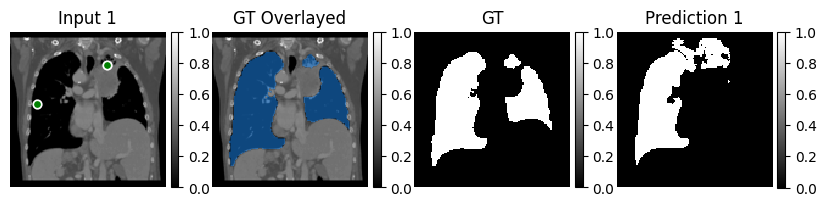

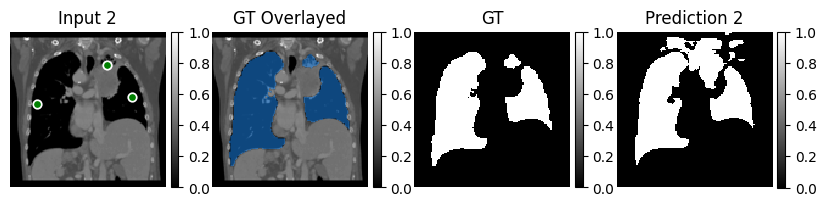

In [19]:
prompt_generator = eval_config(random_clicks)
run_inference(prompt_generator, steps=3)

### Random "Warm Start" Clicks

3 random positive clicks and 3 random negative clicks, followed by 1 (positive or negative) correction click per step in the center of the largest component of the error region

In [20]:
%%yaml random_warm_start
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
click_embed:
  _fn: scribbleprompt.interactions.embed.click_onehot
init_pos_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
init_neg_click_generators:
    - _class: scribbleprompt.interactions.clicks.RandomClick
      train: False
correction_click_generators:
  - _class: scribbleprompt.interactions.clicks.ComponentCenterClick
    train: False
init_pos_click: 3
init_neg_click: 3
correction_clicks: 1
prob_bbox: 0.0
prob_click: 1.0
from_logits: True

<IPython.core.display.Javascript object>

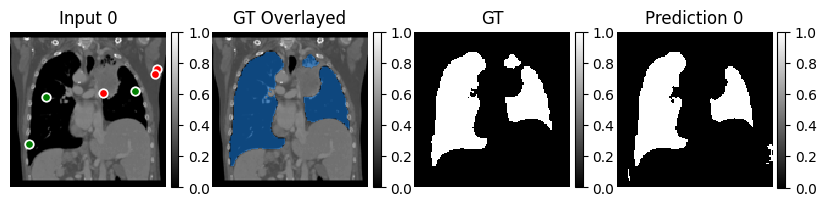

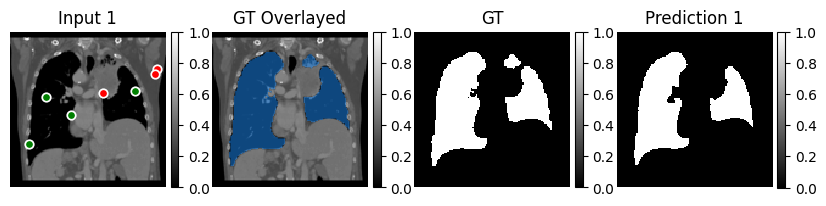

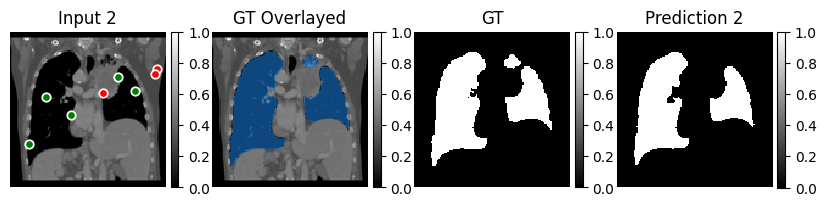

In [21]:
prompt_generator = eval_config(random_warm_start)
run_inference(prompt_generator, steps=3)

## Bounding Boxes

In [22]:
%%yaml box_config
_class: scribbleprompt.interactions.prompt_generator.FlexiblePromptEmbed
bbox_embed:
  _fn: scribbleprompt.interactions.embed.bbox_shaded
box_generators:
  - _class: scribbleprompt.interactions.boxes.UniformBBox
prob_bbox: 1.0
prob_click: 0.0
prob_scribble: 0.0
from_logits: True
single_correction_type: False

<IPython.core.display.Javascript object>

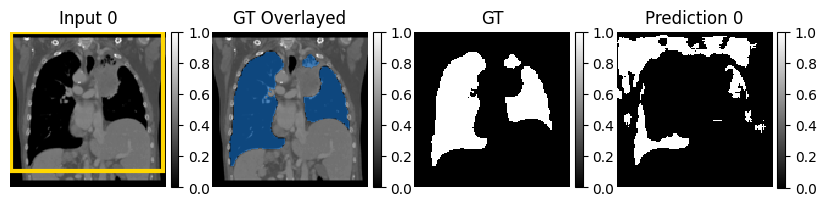

In [23]:
prompt_generator = eval_config(box_config)
run_inference(prompt_generator, steps=1)